In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# Tests to see can fix the OOM problems
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.50'
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union, Type, List
import numpy as np
import matplotlib.pyplot as plt

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

# # PyTorch for Dataloaders
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms

# JAX/Flax
import jax
import jax.numpy as jnp
from jax import random
import flax
from flax import linen as nn
from flax.training import train_state, orbax_utils
import optax
import orbax
import wandb
from tqdm import tqdm

from visualization import visualize as vis
from data import data_functions as df
from models import train_model as trm
from models import generate_model as gen
from models import model_architecture as march

In [2]:
class JaxDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, segmentation = self.dataset[idx]
        # Convert data to numpy arrays
        image = np.array(image)
        segmentation = np.array(segmentation)
        return image, segmentation

In [3]:
# Download the dataset with images & segmentations (as labels)
# resize the images & segmentations to be 224x224
train_set = OxfordIIITPet(root='/home/mdowicz/PFGMPP/data/raw',
                          split='trainval',
                          target_types='segmentation',
                          download=True,
                          transform=transforms.Resize((128, 128)),                   
                          target_transform=transforms.Resize((128, 128)))

# Convert downloaded data to jax compatible datasets/dataloaders
train_set = JaxDataset(dataset=train_set)
train_loader = df.NumpyLoader(dataset=train_set,
                              batch_size=2,
                              shuffle=True)
batch = next(iter(train_loader))

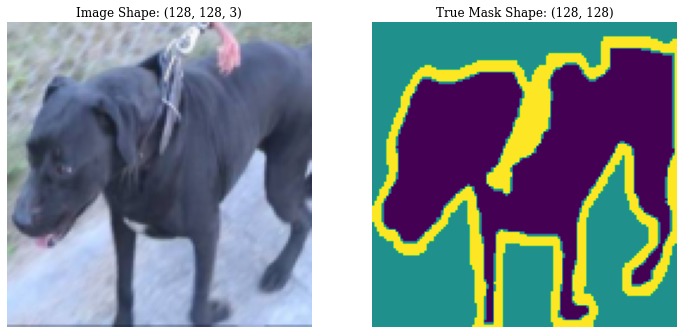

In [4]:
def visualize_sample(batch, idx):
    image, segmentation = batch
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(image[idx])
    ax1.set_title(f"Image Shape: {image[idx].shape}")
    ax1.axis("off")
    
    ax2.imshow(segmentation[idx])
    ax2.set_title(f"True Mask Shape: {segmentation[idx].shape}")
    ax2.axis("off")
    
    plt.show()

visualize_sample(batch, 1)

In [5]:
def init_train_state(model: Any,
                     random_key: Any,
                     x_shape: tuple,
                     learning_rate: int) -> train_state.TrainState:
    """
    Function to initialize the TrainState dataclass, whcih represents
    the entire training state, including step number, parameteers, and 
    optimizer state. Used in a Flax framework because you no longer need
    to initialize the model again & again with new variables. Rather we 
    just update the "state" of the model and pass this as inputs to functions.
    
    Args:
    -----
        model: nn.Module
            Model we want to train.
        random_key: jax.random.PRNGKey()
            Used to trigger the initialization functions, which generate
            the initial set of parameters that the model will use.
        x_shape: tuple
            Shape of the batch of data (x) that will be input into the model.
            Used to trigger shape inference.

        learning_rate: float
            How large of a step the optimizer should take.
            
    Returns:
    --------
        train_state.TrainState:
            A utility class for handling parameter and gradient updates.
    """
    # Initialize the model
    variables = model.init(random_key, jnp.ones(x_shape))
    
    # Create the optimizer
    optimizer = optax.adam(learning_rate)
    
    # Create a state
    return flax.training.train_state.TrainState.create(apply_fn=model.apply,
                                                       tx=optimizer,
                                                       params=variables['params'])

def train_step(state: train_state.TrainState, batch: jnp.ndarray):
    image, segmentation = batch
    segmentation_shifted = segmentation - 1 # makes it 0 indexed (0,1,2) instead of (1,2,3)
    # Define the loss function
    def loss_fn(params):
        pred = state.apply_fn({'params': params}, image)
        loss = optax.softmax_cross_entropy_with_integer_labels(pred, segmentation_shifted).mean()
        return loss
    
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grad = grad_fn(state.params)
    new_state = state.apply_gradients(grads=grad)
    return new_state, loss

def eval_step(state, batch):
    image, segmentation = batch
    segmentation_shifted = segmentation - 1
    pred = state.apply_fn({'params': state.params}, image)
    return optax.softmax_cross_entropy_with_integer_labels(pred, segmentation_shifted).mean()

def accumulate_metrics(metrics):
    """
    Function that accumulates all the per batch metrics into
    per epoch metrics
    """
    metrics = jax.device_get(metrics)
    return {
        k: np.mean([metric[k] for metric in metrics])
        for k in metrics[0]
    }

def save_checkpoint(ckpt_dir: str,
                    state: Any,
                    step: int,
                    wandb_logging: bool = False) -> None:
    """
    Save the training state as a checkpoint

    Args:
    -----
        ckpt_dir: str
            Directory to save the checkpoint files.
        state: Any
            The training state to be saved.
        step: int
            Current training step or epoch number.
        wandb_logging: bool
            If True, uses the wandb run name in the checkpoint filename.
            Default is False.
    """
    ckptr = orbax.checkpoint.Checkpointer(orbax.checkpoint.PyTreeCheckpointHandler())

    # Ensure directory exists
    os.makedirs(ckpt_dir, exist_ok=True)

    # Get the wandb run name or id if wandb logging is enabled
    run_name = wandb.run.name if wandb_logging else ""

    # Create checkpoint file path with the ".flax" extension and the wandb run name if applicable
    ckpt_file = os.path.join(ckpt_dir, f"checkpoint_{run_name}.flax")

    # Save checkpoint to local directory
    ckptr.save(ckpt_file, state,
               save_args=flax.training.orbax_utils.save_args_from_target(state),
               force=True)

    # If wandb logging is enabled, save the checkpoint to wandb run
    if wandb_logging:
        wandb.save(ckpt_file)


def train_model_sweep(train_loader,
                      test_loader,
                      model,
                      state,
                      config,
                      dir_name,
                      project_name,
                      wandb_logging=True):
    """
    Train a machine learning model with optional Weights & Biases (wandb) logging.

    Parameters:
    -----------
    train_loader: 
        A data loader providing the training data.
    model: 
        The model to be trained.
    state: 
        The initial state of the model.
    config: dict
        A dictionary containing configuration parameters for training, such as learning rate, batch size etc.
    wandb_logging: bool
        If True, training progress is logged using wandb.
        Default is False.

    Returns:
    --------
        model: The trained model.
        state: The final state of the model after training.
    """    
    # Initialize a var to hold the best test loss seen so far
    best_test_loss = float('inf')
    
    # Start the training loop
    for epoch in tqdm(range(config['epochs'])):
        # Initialize a list to store all batch-level metrics
        train_batch_metrics = []
        test_batch_metrics = []

        for batch in train_loader:
            # Prepare the data
            batch = jax.device_put(batch)

            # Update the model
            train_step_jit = jax.jit(train_step)
            state, batch_loss = train_step_jit(state, batch)    

            # Store the batch-level metric in the list
            train_batch_metrics.append({'Train Loss': batch_loss})

        # Get the test loss during training
        for batch in test_loader:
            eval_step_jit = jax.jit(eval_step)
            test_batch_loss = eval_step_jit(state, batch)
            test_batch_metrics.append({'Test Loss': test_batch_loss})
            
        # Use accumulate_metrics to calculate average metrics for the epoch
        train_epoch_metrics = accumulate_metrics(train_batch_metrics)
        print('Train Epoch Loss =', train_epoch_metrics)
        test_epoch_metrics = accumulate_metrics(test_batch_metrics)
        print('Test Epoch Loss =', test_epoch_metrics)

        # If the test loss for this epoch is better than the previous best,
        # save the model
        if test_epoch_metrics['Test Loss'] < best_test_loss:
            best_test_loss = test_epoch_metrics['Test Loss'] # Update the best test loss
            checkpt_dir = dir_name # dir where models are saved to
            save_checkpoint(checkpt_dir, state, epoch, project_name)

        # If wandb logging is enabled, log metrics
        if wandb_logging:
            wandb.log(train_epoch_metrics)
            wandb.log(test_epoch_metrics)

    # checkpt_dir = dir_name # dir to save the checkpoints
    # save_checkpoint(checkpt_dir, state, config['epochs'], project_name)

    return model, state

def train_sweep(config=None, project_name='toy_UNet', dir_name='PFGMPP/saved_models/UNET_toy'):
    # Create random PRNG keys for training
    init_rng = random.PRNGKey(0)
    rng, subkey1, subkey2, subkey3 = random.split(init_rng, num=4)

    # Get the absolute path of the saved_models/toy directory
    dir_name = os.path.join(os.path.expanduser('~'), str(dir_name)) #FIX THIS HARDCODE
    
    # If wandb logging is enabled, initialize wandb
    with wandb.init(config=config, dir=dir_name):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        train_set = OxfordIIITPet(root='/home/mdowicz/PFGMPP/data/raw',
                                  split='trainval',
                                  target_types='segmentation',
                                  download=True,
                                  transform=transforms.Resize((128, 128)),                   
                                  target_transform=transforms.Resize((128, 128)))
        train_set = JaxDataset(dataset=train_set)
        train_loader = df.NumpyLoader(dataset=train_set,
                                      batch_size=config['batch_size'],
                                      shuffle=True)
        train_batch = next(iter(train_loader))

        test_set = OxfordIIITPet(root='/home/mdowicz/PFGMPP/data/raw',
                                 split='test',
                                 target_types='segmentation',
                                 download=True,
                                 transform=transforms.Resize((128, 128)),
                                 target_transform=transforms.Resize((128, 128)))
        test_set = JaxDataset(dataset=test_set)
        test_loader = df.NumpyLoader(dataset=test_set,
                                     batch_size=config['batch_size'],
                                     shuffle=False)
        
        # Get the rng & model instantiated
        init_rng = random.PRNGKey(config['seed'])
        model = march.UNet(depth=config['depth'],
                     initial_filters=config['initial_filters'],
                     output_channels=config['output_channels'])
        
        # Initialize the models state
        state = init_train_state(model=model,
                                 random_key=init_rng,
                                 x_shape=train_batch[0].shape,
                                 learning_rate=config['learning_rate'])
        
        # Call the training function
        model, state = train_model_sweep(train_loader,
                                         test_loader,
                                         model,
                                         state,
                                         config,
                                         wandb_logging=True,
                                         project_name=project_name,
                                         dir_name=dir_name)


        del state
        del model
        del train_set
        del train_loader
        del test_set
        del test_loader
        wandb.finish()

In [6]:
config = {
    'method': 'random',
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
        'optimizer': {
            'value': 'adam'
        },
        'seed': {
            'value': 10
        },
        'epochs': {
            'value': 50
        },
        'batch_size': {
            'values': [10, 20]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'depth': {
            'value': 5
        },
        'initial_filters': {
            'values': [32, 64]
        },
        'output_channels': {
            'value': 3
        }
    }
}
import pprint
pprint.pprint(config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'values': [10, 20]},
                'depth': {'value': 5},
                'epochs': {'value': 50},
                'initial_filters': {'values': [32, 64]},
                'learning_rate': {'values': [0.001, 0.0001]},
                'optimizer': {'value': 'adam'},
                'output_channels': {'value': 3},
                'seed': {'value': 10}}}


In [7]:
sweep_id = wandb.sweep(config, project='toy_UNET')
wandb.agent(sweep_id, train_sweep, count=3)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: znunwmco
Sweep URL: https://wandb.ai/mdowicz/toy_UNET/sweeps/znunwmco


wandb: Agent Starting Run: pyzbjqg1 with config:
wandb: 	batch_size: 10
wandb: 	depth: 5
wandb: 	epochs: 50
wandb: 	initial_filters: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	output_channels: 3
wandb: 	seed: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mdowicz. Use `wandb login --relogin` to force relogin


  0%|          | 0/50 [00:00<?, ?it/s]

Train Epoch Loss = {'Train Loss': 1.0505046}
Test Epoch Loss = {'Test Loss': 0.70365685}


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
  2%|▏         | 1/50 [00:55<45:15, 55.42s/it]

Train Epoch Loss = {'Train Loss': 0.62690043}
Test Epoch Loss = {'Test Loss': 0.55672723}


  4%|▍         | 2/50 [01:38<38:19, 47.91s/it]

Train Epoch Loss = {'Train Loss': 0.5289239}
Test Epoch Loss = {'Test Loss': 0.50295734}


  6%|▌         | 3/50 [02:20<35:40, 45.53s/it]

Train Epoch Loss = {'Train Loss': 0.47081542}
Test Epoch Loss = {'Test Loss': 0.46426192}


  8%|▊         | 4/50 [03:03<34:03, 44.43s/it]

Train Epoch Loss = {'Train Loss': 0.42688477}
Test Epoch Loss = {'Test Loss': 0.41384676}


 12%|█▏        | 6/50 [04:25<31:02, 42.32s/it]

Train Epoch Loss = {'Train Loss': 0.393654}
Test Epoch Loss = {'Test Loss': 0.41804653}
Train Epoch Loss = {'Train Loss': 0.36192313}
Test Epoch Loss = {'Test Loss': 0.40980017}


 14%|█▍        | 7/50 [05:08<30:24, 42.44s/it]

Train Epoch Loss = {'Train Loss': 0.336854}
Test Epoch Loss = {'Test Loss': 0.37254167}


 18%|█▊        | 9/50 [06:30<28:23, 41.54s/it]

Train Epoch Loss = {'Train Loss': 0.30929738}
Test Epoch Loss = {'Test Loss': 0.3972907}


 20%|██        | 10/50 [07:09<27:15, 40.88s/it]

Train Epoch Loss = {'Train Loss': 0.29345384}
Test Epoch Loss = {'Test Loss': 0.3772362}


 22%|██▏       | 11/50 [07:49<26:16, 40.43s/it]

Train Epoch Loss = {'Train Loss': 0.2850134}
Test Epoch Loss = {'Test Loss': 0.38361818}


 24%|██▍       | 12/50 [08:28<25:25, 40.13s/it]

Train Epoch Loss = {'Train Loss': 0.2697332}
Test Epoch Loss = {'Test Loss': 0.3760737}
Train Epoch Loss = {'Train Loss': 0.24083963}
Test Epoch Loss = {'Test Loss': 0.3658656}


 26%|██▌       | 13/50 [09:11<25:13, 40.91s/it]

Train Epoch Loss = {'Train Loss': 0.23244953}
Test Epoch Loss = {'Test Loss': 0.360017}


 30%|███       | 15/50 [10:33<23:49, 40.84s/it]

Train Epoch Loss = {'Train Loss': 0.22230059}
Test Epoch Loss = {'Test Loss': 0.38291794}


 32%|███▏      | 16/50 [11:12<22:54, 40.43s/it]

Train Epoch Loss = {'Train Loss': 0.22571817}
Test Epoch Loss = {'Test Loss': 0.39973536}


 34%|███▍      | 17/50 [11:52<22:03, 40.12s/it]

Train Epoch Loss = {'Train Loss': 0.21173234}
Test Epoch Loss = {'Test Loss': 0.4307631}


 36%|███▌      | 18/50 [12:31<21:17, 39.92s/it]

Train Epoch Loss = {'Train Loss': 0.20271316}
Test Epoch Loss = {'Test Loss': 0.4064909}


 38%|███▊      | 19/50 [13:11<20:34, 39.81s/it]

Train Epoch Loss = {'Train Loss': 0.17751482}
Test Epoch Loss = {'Test Loss': 0.3970845}


 40%|████      | 20/50 [13:50<19:50, 39.69s/it]

Train Epoch Loss = {'Train Loss': 0.21150494}
Test Epoch Loss = {'Test Loss': 0.3858348}


 42%|████▏     | 21/50 [14:30<19:09, 39.63s/it]

Train Epoch Loss = {'Train Loss': 0.19189581}
Test Epoch Loss = {'Test Loss': 0.40497997}


 44%|████▍     | 22/50 [15:09<18:29, 39.61s/it]

Train Epoch Loss = {'Train Loss': 0.16464065}
Test Epoch Loss = {'Test Loss': 0.41117504}


 46%|████▌     | 23/50 [15:49<17:48, 39.57s/it]

Train Epoch Loss = {'Train Loss': 0.1622664}
Test Epoch Loss = {'Test Loss': 0.42990777}


 48%|████▊     | 24/50 [16:28<17:08, 39.55s/it]

Train Epoch Loss = {'Train Loss': 0.1461507}
Test Epoch Loss = {'Test Loss': 0.44185087}


 50%|█████     | 25/50 [17:08<16:27, 39.51s/it]

Train Epoch Loss = {'Train Loss': 0.13766707}
Test Epoch Loss = {'Test Loss': 0.43462995}


 52%|█████▏    | 26/50 [17:47<15:47, 39.48s/it]

Train Epoch Loss = {'Train Loss': 0.13127205}
Test Epoch Loss = {'Test Loss': 0.5162484}


 54%|█████▍    | 27/50 [18:27<15:07, 39.47s/it]

Train Epoch Loss = {'Train Loss': 0.17260806}
Test Epoch Loss = {'Test Loss': 0.42827204}


 56%|█████▌    | 28/50 [19:06<14:28, 39.49s/it]

Train Epoch Loss = {'Train Loss': 0.14869416}
Test Epoch Loss = {'Test Loss': 0.47919342}


 58%|█████▊    | 29/50 [19:46<13:49, 39.48s/it]

Train Epoch Loss = {'Train Loss': 0.12591457}
Test Epoch Loss = {'Test Loss': 0.4806806}


 60%|██████    | 30/50 [20:25<13:09, 39.47s/it]

Train Epoch Loss = {'Train Loss': 0.11396916}
Test Epoch Loss = {'Test Loss': 0.5470676}


 62%|██████▏   | 31/50 [21:05<12:29, 39.47s/it]

Train Epoch Loss = {'Train Loss': 0.10677767}
Test Epoch Loss = {'Test Loss': 0.5539596}


 64%|██████▍   | 32/50 [21:44<11:50, 39.48s/it]

Train Epoch Loss = {'Train Loss': 0.10284122}
Test Epoch Loss = {'Test Loss': 0.5709007}


 66%|██████▌   | 33/50 [22:24<11:11, 39.50s/it]

Train Epoch Loss = {'Train Loss': 0.09957893}
Test Epoch Loss = {'Test Loss': 0.5865724}


 68%|██████▊   | 34/50 [23:03<10:31, 39.49s/it]

Train Epoch Loss = {'Train Loss': 0.14290613}
Test Epoch Loss = {'Test Loss': 0.4959968}


 70%|███████   | 35/50 [23:42<09:51, 39.46s/it]

Train Epoch Loss = {'Train Loss': 0.12571919}
Test Epoch Loss = {'Test Loss': 0.51396406}


 72%|███████▏  | 36/50 [24:22<09:12, 39.44s/it]

Train Epoch Loss = {'Train Loss': 0.09842981}
Test Epoch Loss = {'Test Loss': 0.56120706}


 74%|███████▍  | 37/50 [25:01<08:32, 39.43s/it]

Train Epoch Loss = {'Train Loss': 0.08817793}
Test Epoch Loss = {'Test Loss': 0.6210363}


 76%|███████▌  | 38/50 [25:41<07:52, 39.42s/it]

Train Epoch Loss = {'Train Loss': 0.08098801}
Test Epoch Loss = {'Test Loss': 0.66391206}


 78%|███████▊  | 39/50 [26:20<07:13, 39.42s/it]

Train Epoch Loss = {'Train Loss': 0.07794648}
Test Epoch Loss = {'Test Loss': 0.67771333}


 80%|████████  | 40/50 [26:59<06:34, 39.43s/it]

Train Epoch Loss = {'Train Loss': 0.07606317}
Test Epoch Loss = {'Test Loss': 0.6886433}


 82%|████████▏ | 41/50 [27:39<05:54, 39.44s/it]

Train Epoch Loss = {'Train Loss': 0.07412961}
Test Epoch Loss = {'Test Loss': 0.71071714}


 84%|████████▍ | 42/50 [28:18<05:15, 39.44s/it]

Train Epoch Loss = {'Train Loss': 0.072242476}
Test Epoch Loss = {'Test Loss': 0.68620986}


 86%|████████▌ | 43/50 [28:58<04:36, 39.43s/it]

Train Epoch Loss = {'Train Loss': 0.07978919}
Test Epoch Loss = {'Test Loss': 0.63848436}


 88%|████████▊ | 44/50 [29:37<03:56, 39.43s/it]

Train Epoch Loss = {'Train Loss': 0.15466951}
Test Epoch Loss = {'Test Loss': 0.512213}


 90%|█████████ | 45/50 [30:17<03:17, 39.43s/it]

Train Epoch Loss = {'Train Loss': 0.093277104}
Test Epoch Loss = {'Test Loss': 0.5944531}


 92%|█████████▏| 46/50 [30:56<02:37, 39.43s/it]

Train Epoch Loss = {'Train Loss': 0.07175827}
Test Epoch Loss = {'Test Loss': 0.68260086}


 94%|█████████▍| 47/50 [31:35<01:58, 39.42s/it]

Train Epoch Loss = {'Train Loss': 0.061037842}
Test Epoch Loss = {'Test Loss': 0.7592662}


 96%|█████████▌| 48/50 [32:15<01:18, 39.42s/it]

Train Epoch Loss = {'Train Loss': 0.057317656}
Test Epoch Loss = {'Test Loss': 0.7663595}


 98%|█████████▊| 49/50 [32:54<00:39, 39.42s/it]

Train Epoch Loss = {'Train Loss': 0.056971308}
Test Epoch Loss = {'Test Loss': 0.7843754}


100%|██████████| 50/50 [33:34<00:00, 40.29s/it]

Train Epoch Loss = {'Train Loss': 0.05700795}
Test Epoch Loss = {'Test Loss': 0.7834353}


Test Loss,▇▄▃▃▂▂▁▂▁▁▁▁▂▂▂▂▂▂▂▂▄▂▃▃▄▄▅▃▄▅▆▆▇▆▆▄▆███
Train Loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁
Test Loss,0.78344
Train Loss,0.05701


wandb: Agent Starting Run: jlttzf22 with config:
wandb: 	batch_size: 20
wandb: 	depth: 5
wandb: 	epochs: 50
wandb: 	initial_filters: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	output_channels: 3
wandb: 	seed: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


  0%|          | 0/50 [00:00<?, ?it/s]

Train Epoch Loss = {'Train Loss': 1.7799484}
Test Epoch Loss = {'Test Loss': 0.9479628}


  2%|▏         | 1/50 [00:44<36:36, 44.83s/it]

Train Epoch Loss = {'Train Loss': 0.7725671}
Test Epoch Loss = {'Test Loss': 0.7574732}


  4%|▍         | 2/50 [01:17<30:12, 37.76s/it]

Train Epoch Loss = {'Train Loss': 0.66672415}
Test Epoch Loss = {'Test Loss': 0.62677115}


  6%|▌         | 3/50 [01:50<27:49, 35.51s/it]

Train Epoch Loss = {'Train Loss': 0.5603583}
Test Epoch Loss = {'Test Loss': 0.56041956}


 10%|█         | 5/50 [02:55<25:11, 33.58s/it]

Train Epoch Loss = {'Train Loss': 0.510594}
Test Epoch Loss = {'Test Loss': 0.56266296}
Train Epoch Loss = {'Train Loss': 0.4704214}
Test Epoch Loss = {'Test Loss': 0.47137788}


 14%|█▍        | 7/50 [04:00<23:35, 32.93s/it]

Train Epoch Loss = {'Train Loss': 0.44001907}
Test Epoch Loss = {'Test Loss': 0.47396386}
Train Epoch Loss = {'Train Loss': 0.4057917}
Test Epoch Loss = {'Test Loss': 0.4639065}


 18%|█▊        | 9/50 [05:05<22:19, 32.67s/it]

Train Epoch Loss = {'Train Loss': 0.37308037}
Test Epoch Loss = {'Test Loss': 0.46404046}


 20%|██        | 10/50 [05:37<21:40, 32.51s/it]

Train Epoch Loss = {'Train Loss': 0.35279578}
Test Epoch Loss = {'Test Loss': 0.47546503}
Train Epoch Loss = {'Train Loss': 0.32722825}
Test Epoch Loss = {'Test Loss': 0.4465561}


 24%|██▍       | 12/50 [06:42<20:34, 32.48s/it]

Train Epoch Loss = {'Train Loss': 0.3158656}
Test Epoch Loss = {'Test Loss': 0.46649244}
Train Epoch Loss = {'Train Loss': 0.29229078}
Test Epoch Loss = {'Test Loss': 0.44469243}


 26%|██▌       | 13/50 [07:15<20:05, 32.58s/it]

Train Epoch Loss = {'Train Loss': 0.27319768}
Test Epoch Loss = {'Test Loss': 0.4213136}


 30%|███       | 15/50 [08:20<18:57, 32.49s/it]

Train Epoch Loss = {'Train Loss': 0.2598603}
Test Epoch Loss = {'Test Loss': 0.44384342}


 32%|███▏      | 16/50 [08:52<18:20, 32.37s/it]

Train Epoch Loss = {'Train Loss': 0.24671608}
Test Epoch Loss = {'Test Loss': 0.4651681}


 34%|███▍      | 17/50 [09:24<17:47, 32.34s/it]

Train Epoch Loss = {'Train Loss': 0.23618856}
Test Epoch Loss = {'Test Loss': 0.4479492}


 36%|███▌      | 18/50 [09:56<17:12, 32.28s/it]

Train Epoch Loss = {'Train Loss': 0.22728221}
Test Epoch Loss = {'Test Loss': 0.4533522}


 38%|███▊      | 19/50 [10:28<16:39, 32.23s/it]

Train Epoch Loss = {'Train Loss': 0.21394958}
Test Epoch Loss = {'Test Loss': 0.45563284}


 40%|████      | 20/50 [11:01<16:06, 32.21s/it]

Train Epoch Loss = {'Train Loss': 0.23836792}
Test Epoch Loss = {'Test Loss': 0.443983}


 42%|████▏     | 21/50 [11:33<15:33, 32.18s/it]

Train Epoch Loss = {'Train Loss': 0.22045475}
Test Epoch Loss = {'Test Loss': 0.48528215}


 44%|████▍     | 22/50 [12:05<15:00, 32.15s/it]

Train Epoch Loss = {'Train Loss': 0.19749728}
Test Epoch Loss = {'Test Loss': 0.5087518}


 46%|████▌     | 23/50 [12:37<14:27, 32.11s/it]

Train Epoch Loss = {'Train Loss': 0.18621664}
Test Epoch Loss = {'Test Loss': 0.48251036}


 48%|████▊     | 24/50 [13:09<13:54, 32.10s/it]

Train Epoch Loss = {'Train Loss': 0.17794165}
Test Epoch Loss = {'Test Loss': 0.5350204}


 50%|█████     | 25/50 [13:41<13:20, 32.03s/it]

Train Epoch Loss = {'Train Loss': 0.17253779}
Test Epoch Loss = {'Test Loss': 0.5179876}


 52%|█████▏    | 26/50 [14:13<12:47, 31.99s/it]

Train Epoch Loss = {'Train Loss': 0.16768497}
Test Epoch Loss = {'Test Loss': 0.5505007}


 54%|█████▍    | 27/50 [14:44<12:15, 31.97s/it]

Train Epoch Loss = {'Train Loss': 0.16382219}
Test Epoch Loss = {'Test Loss': 0.53873086}


 56%|█████▌    | 28/50 [15:16<11:42, 31.93s/it]

Train Epoch Loss = {'Train Loss': 0.17018832}
Test Epoch Loss = {'Test Loss': 0.54819316}


 58%|█████▊    | 29/50 [15:48<11:10, 31.93s/it]

Train Epoch Loss = {'Train Loss': 0.15441656}
Test Epoch Loss = {'Test Loss': 0.5480626}


 60%|██████    | 30/50 [16:20<10:38, 31.93s/it]

Train Epoch Loss = {'Train Loss': 0.14913294}
Test Epoch Loss = {'Test Loss': 0.59850997}


 62%|██████▏   | 31/50 [16:52<10:06, 31.94s/it]

Train Epoch Loss = {'Train Loss': 0.21208975}
Test Epoch Loss = {'Test Loss': 0.50034446}


 64%|██████▍   | 32/50 [17:24<09:35, 31.95s/it]

Train Epoch Loss = {'Train Loss': 0.16473274}
Test Epoch Loss = {'Test Loss': 0.53324383}


 66%|██████▌   | 33/50 [17:56<09:03, 31.94s/it]

Train Epoch Loss = {'Train Loss': 0.14092222}
Test Epoch Loss = {'Test Loss': 0.5574932}


 68%|██████▊   | 34/50 [18:28<08:30, 31.93s/it]

Train Epoch Loss = {'Train Loss': 0.13092329}
Test Epoch Loss = {'Test Loss': 0.6007167}


 70%|███████   | 35/50 [19:00<07:58, 31.92s/it]

Train Epoch Loss = {'Train Loss': 0.12599866}
Test Epoch Loss = {'Test Loss': 0.66496056}


 72%|███████▏  | 36/50 [19:32<07:26, 31.90s/it]

Train Epoch Loss = {'Train Loss': 0.123437755}
Test Epoch Loss = {'Test Loss': 0.643885}


 74%|███████▍  | 37/50 [20:04<06:54, 31.89s/it]

Train Epoch Loss = {'Train Loss': 0.1198865}
Test Epoch Loss = {'Test Loss': 0.6539068}


 76%|███████▌  | 38/50 [20:35<06:22, 31.88s/it]

Train Epoch Loss = {'Train Loss': 0.11666244}
Test Epoch Loss = {'Test Loss': 0.6657505}


 78%|███████▊  | 39/50 [21:07<05:50, 31.88s/it]

Train Epoch Loss = {'Train Loss': 0.11366251}
Test Epoch Loss = {'Test Loss': 0.6996519}


 80%|████████  | 40/50 [21:39<05:19, 31.91s/it]

Train Epoch Loss = {'Train Loss': 0.11193719}
Test Epoch Loss = {'Test Loss': 0.67408353}


 82%|████████▏ | 41/50 [22:11<04:47, 31.89s/it]

Train Epoch Loss = {'Train Loss': 0.11018126}
Test Epoch Loss = {'Test Loss': 0.6690075}


 84%|████████▍ | 42/50 [22:43<04:15, 31.90s/it]

Train Epoch Loss = {'Train Loss': 0.10655861}
Test Epoch Loss = {'Test Loss': 0.699192}


 86%|████████▌ | 43/50 [23:15<03:43, 31.91s/it]

Train Epoch Loss = {'Train Loss': 0.103796676}
Test Epoch Loss = {'Test Loss': 0.73665404}


 88%|████████▊ | 44/50 [23:47<03:11, 31.92s/it]

Train Epoch Loss = {'Train Loss': 0.10056434}
Test Epoch Loss = {'Test Loss': 0.73635584}


 90%|█████████ | 45/50 [24:19<02:39, 31.93s/it]

Train Epoch Loss = {'Train Loss': 0.09844274}
Test Epoch Loss = {'Test Loss': 0.7619536}


 92%|█████████▏| 46/50 [24:51<02:07, 31.93s/it]

Train Epoch Loss = {'Train Loss': 0.096045636}
Test Epoch Loss = {'Test Loss': 0.74096316}


 94%|█████████▍| 47/50 [25:23<01:35, 31.93s/it]

Train Epoch Loss = {'Train Loss': 0.13260688}
Test Epoch Loss = {'Test Loss': 0.5106706}


 96%|█████████▌| 48/50 [25:55<01:03, 31.94s/it]

Train Epoch Loss = {'Train Loss': 0.14136922}
Test Epoch Loss = {'Test Loss': 0.63673097}


 98%|█████████▊| 49/50 [26:27<00:31, 31.97s/it]

Train Epoch Loss = {'Train Loss': 0.09749054}
Test Epoch Loss = {'Test Loss': 0.6760812}


100%|██████████| 50/50 [26:59<00:00, 32.38s/it]

Train Epoch Loss = {'Train Loss': 0.085410275}
Test Epoch Loss = {'Test Loss': 0.76178896}


Test Loss,█▅▄▃▂▂▂▂▁▂▁▁▂▁▁▁▂▂▂▃▃▃▃▃▂▂▃▃▄▄▄▅▄▅▅▅▅▂▄▆
Train Loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Loss,0.76179
Train Loss,0.08541


wandb: Agent Starting Run: xn008v8y with config:
wandb: 	batch_size: 20
wandb: 	depth: 5
wandb: 	epochs: 50
wandb: 	initial_filters: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	output_channels: 3
wandb: 	seed: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


  0%|          | 0/50 [00:00<?, ?it/s]

Train Epoch Loss = {'Train Loss': 1.2675424}
Test Epoch Loss = {'Test Loss': 0.87497926}


  2%|▏         | 1/50 [00:55<45:39, 55.91s/it]

Train Epoch Loss = {'Train Loss': 0.68117476}
Test Epoch Loss = {'Test Loss': 0.6159125}


  4%|▍         | 2/50 [01:33<36:18, 45.38s/it]

Train Epoch Loss = {'Train Loss': 0.56067187}
Test Epoch Loss = {'Test Loss': 0.5158865}


  6%|▌         | 3/50 [02:11<32:53, 42.00s/it]

Train Epoch Loss = {'Train Loss': 0.50096476}
Test Epoch Loss = {'Test Loss': 0.47999308}


 10%|█         | 5/50 [03:24<28:44, 38.32s/it]

Train Epoch Loss = {'Train Loss': 0.46663818}
Test Epoch Loss = {'Test Loss': 0.49155617}


 12%|█▏        | 6/50 [03:59<27:11, 37.08s/it]

Train Epoch Loss = {'Train Loss': 0.417722}
Test Epoch Loss = {'Test Loss': 0.48466283}
Train Epoch Loss = {'Train Loss': 0.38185287}
Test Epoch Loss = {'Test Loss': 0.43931356}


 14%|█▍        | 7/50 [04:37<26:46, 37.37s/it]

Train Epoch Loss = {'Train Loss': 0.35714394}
Test Epoch Loss = {'Test Loss': 0.4348684}


 16%|█▌        | 8/50 [05:14<26:16, 37.53s/it]

Train Epoch Loss = {'Train Loss': 0.33390933}
Test Epoch Loss = {'Test Loss': 0.40577453}


 18%|█▊        | 9/50 [06:02<27:33, 40.33s/it]


Test Loss,█▄▃▂▂▂▂▁▁
Train Loss,█▄▃▂▂▂▁▁▁
Test Loss,0.40577
Train Loss,0.33391
